# Sankey Diagram of Data in Data Commons

The purpose of this notebook is to provide a visual representation of the availability and connectivity of some of the data in the Data Commons.  The Data are:
* EPA_GHGRP: Asset-level data (physical plants and operations in the US that emit >= 25 kt CO2e and others covered by GHG Reporting Project)
* GLEIF: Legal Entity Identifiers for parent companies that own assets (and identification of parent companies that don't have LEIs)
* Type of emissions from parent companies: Direct Emitters, LDC Emissions, On-Shore Refining, Gathering and Boosting, Transmission Pipelines, SF6 from Electrical Equipment
* Types of operations by SIC/NAICS codes (Steel, Cement, Electricity Generation, Pulp and Paper Manufacturing, etc)
* Sectors (Manufacturing, Transportation Communications and Utilities, Service Industries, Mining, etc)
* SEC 10-K reports: Revenue Data (can be compared/contrasted with EPA CO2e emissions data)

The data developed in this notebook comes from https://github.com/os-climate/data-platform-demo/blob/iceberg/notebooks/EPA_GHGRP-demos.ipynb  
and can be visualized by SuperSet here: https://superset-secure-odh-superset.apps.odh-cl2.apps.os-climate.org/

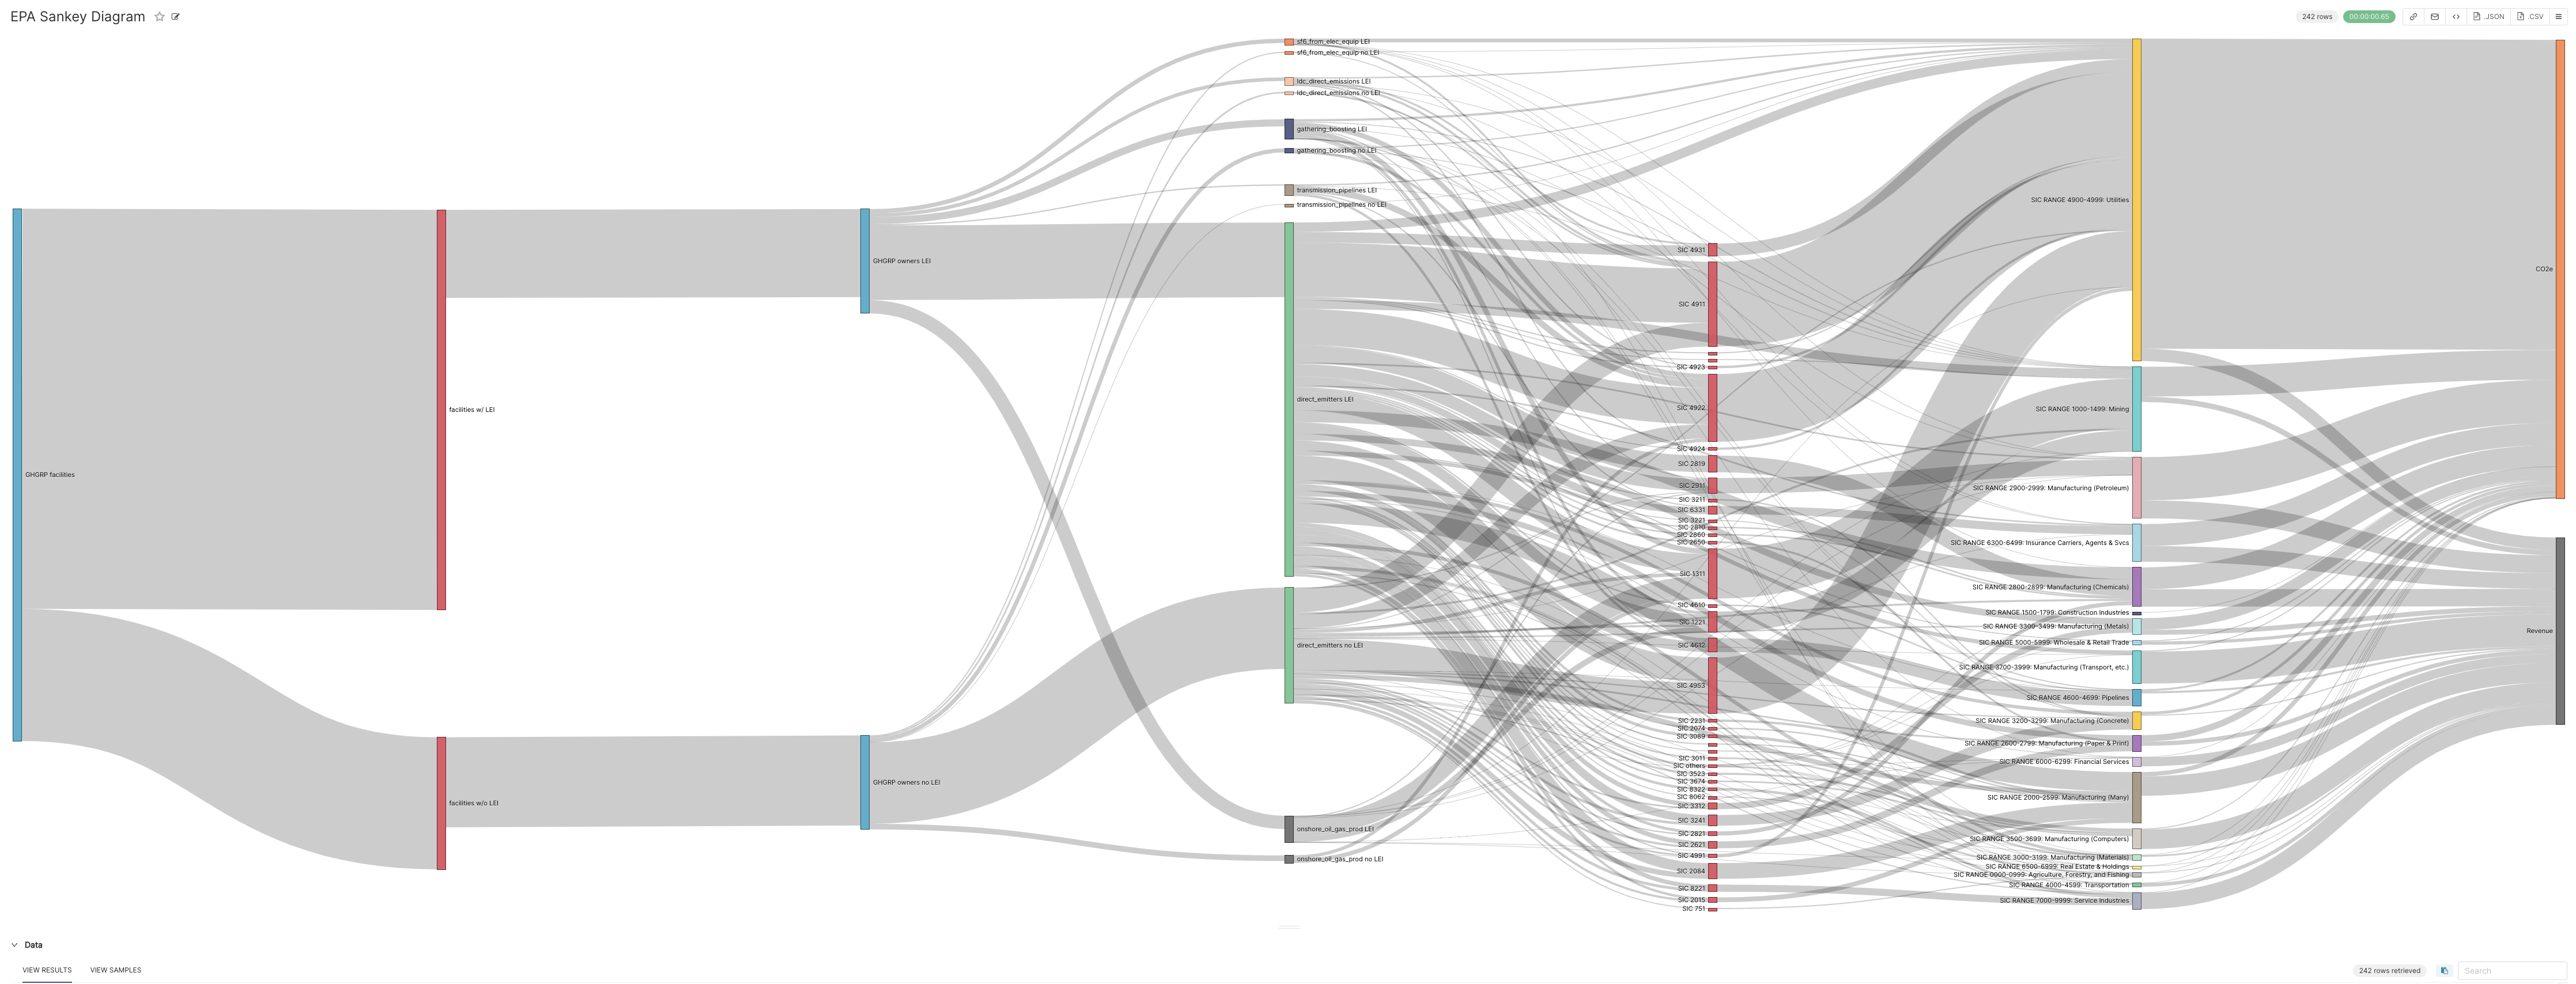

This data is incomplete from a number of perspectives:
* Major non-emitting power plants (hydro electric dams, solar arrays, wind turbines, and nuclear powerplants) may be missing as assets
* There are no metrics for energy generation or consumption, nor for other units of production (such as tons of steel produced)
* All emissions are essentially Scope 1 emissions; there are no Scope 2 attributions for major energy consumers (such as Steel manufacturing)
* There are also no Scope 3 metrics
* The data is exclusively US-based

Despite these shortcomings, this illustration/demonstration shows how additional data can be linked in to provide a more complete picture:
* WRI Power Plant data, providing a global perspective on power plants, including emissions, generation, capacity, fuel type, etc.
* RMI Utility Transition Hub data, providing fine-grained, up-to-date information about US power plants, including emissions targets
* SEC data at Business Segment level (to separate Berkshire Hathaway's \\$65B energy business from their overall \\$265B enterprise, for example)
* SPGI sustainability reports (require NLP analysis to yield quantitative metrics)
* etc.

### Begin with Credentials and Connection to Trino

In [ ]:
import os
import pathlib
from dotenv import load_dotenv

# Load some standard environment variables from a dot-env file, if it exists.
# If no such file can be found, does not fail, and so allows these environment vars to
# be populated in some other way
dotenv_dir = os.environ.get('CREDENTIAL_DOTENV_DIR', os.environ.get('PWD', '/opt/app-root/src'))
dotenv_path = pathlib.Path(dotenv_dir) / 'credentials.env'
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path=dotenv_path,override=True)

Set session variable CATALOG and SCHEMA to make query terms much more compact

In [ ]:
import trino
from sqlalchemy.engine import create_engine

env_var_prefix = 'TRINO'

sqlstring = 'trino://{user}@{host}:{port}/'.format(
    user = os.environ[f'{env_var_prefix}_USER'],
    host = os.environ[f'{env_var_prefix}_HOST'],
    port = os.environ[f'{env_var_prefix}_PORT']
)

ingest_catalog = 'osc_datacommons_dev'
ingest_schema = 'sandbox'
census_table_prefix = 'census_'
dera_table_prefix = 'dera_'
epa_table_prefix = 'epa_'

sqlargs = {
    'auth': trino.auth.JWTAuthentication(os.environ[f'{env_var_prefix}_PASSWD']),
    'http_scheme': 'https',
    'catalog': ingest_catalog,
    'schema': ingest_schema,
}
engine = create_engine(sqlstring, connect_args = sqlargs)
connection = engine.connect()

import pandas as pd

import osc_ingest_trino as osc

Leftmost in the diagram are the facilities.  Some facilities are owned by entities with known LEIs, others are missing LEI data.

This is already fraught in that ghgrp_facility_id `1002251` has 61 parent company owners, `1002265` has 32, and the next 17 have 10 or more owners.  Thus, a single facility may register has having numerous parent companies in both categories if we do this query naively.  And there are 22 cases where identical owners are listed multiple times (leading to an overcount of number of entities, LEI or no).

In [ ]:
fac_lei_list = engine.execute(f"""
select count (*), lei from {epa_table_prefix}parent_attribution as PA
where PA.lei is not null and YEAR(PA.reporting_year)=2020
group by lei
order by count (*) desc""").fetchall()

fac_nolei_list = engine.execute(f"""
select count (*), parent_company_name from {epa_table_prefix}parent_attribution as PA
where PA.lei is null and YEAR(PA.reporting_year)=2020
group by parent_company_name
order by count (*) desc""").fetchall()

Companies reporting to the SEC DERA database list their primary SIC code.  `SIC_NOLIST_LEI_LIST` contains a list of SIC codes reported to SEC DERA that are not otherwise listed in the EPA GHGRP data.

At the moment, our SEC DERA data lists comapanies according to their most prevelant revenue stream.  Berkshire Hathaway has multibillion-dollar subsidiaries that cover steel, oil and gas, utilties, chemical manufacturing, etc.  If we cannot attribute to more specific industries, it makes their primary business--Insurance--look like a major source of emissions, which is not really true.

Facilities in the EPA GHGRP dataset are categorized by a NAICS (not SIC) code.  `naics_nolist_nolei_list` contains the list of NAICS codes that will not be overriden by the SIC code of a publicly reporting company.  Throughout the rest of the code we deal in terms of `primary_naics_code` which is how emissions classified by type are reported.  But here we are just gathering the outliers of `facility_naics_code` values that cannot be crosswalked to SIC codes.

List entities for which we have RMI data about revenues and co2 emissions that are not otherwise captured by EPA/SEC datasets.  In a perfect world, the only data excluded would be those entities that have no LEI with which to connect.  In practice, misalignment between EPA, SEC, and RMI entity matching can cause gaps.

Many utilities merely resell power generated by other facilities.  We prorate reported revenues by the fraction of energy they generate themselves vs. power purchase agreements.  A utility that only purchases power from others (no own generation) would prorate to zero "own revenues" and "own emissions".

Note that Versant Power is owned by Enmax (Toronto).

In [ ]:
rmi_other_revenues_list = engine.execute(f"""
with own_gen as
       (select sum(generation) as own_generation, year, parent_lei
        from operations_emissions_by_fuel EF join utility_information U on EF.respondent_id=U.respondent_id
        group by year, parent_lei),
     dist as
       (select sum(sales) / 1e6 as distribution, year, parent_lei
        from customers_sales CS  join utility_information U on CS.respondent_id=U.respondent_id
        group by year, parent_lei)
select U.parent_name, U.parent_lei, D.distribution as distribution, 'TWh' as distribution_units,
       OG.own_generation as own_generation, 'TWh' as own_generation_units,
       sum(revenues) as revenues,
       sum(revenues)*OG.own_generation/D.distribution as frac_revenues,
       DATE(CS.year)
from utility_information U join customers_sales CS on U.respondent_id=CS.respondent_id
     join own_gen OG on U.parent_lei=OG.parent_lei and CS.year=OG.year
     join dist D on U.parent_lei=D.parent_lei and CS.year=D.year
     left join epa_parent_attribution PA on U.parent_lei=PA.lei and CS.year=PA.reporting_year
where year(CS.year)=2020 and utility_id_eia!=56505
      and OG.own_generation > 0
      and PA.lei IS NULL
group by U.parent_name, U.parent_lei, D.distribution, 4, OG.own_generation, 6, DATE(CS.year)
-- having sum(OG.own_generation)>0
order by U.parent_name
limit 100
""").fetchall()

In [ ]:
rmi_other_revenues_list

In [ ]:
rmi_other_emissions_list = engine.execute(f"""
with own_gen as
       (select sum(generation) as own_generation, year, parent_lei
        from operations_emissions_by_fuel EF join utility_information U on EF.respondent_id=U.respondent_id
        group by year, parent_lei)
select U.parent_name, U.parent_lei, sum(emissions_co2) as emissions, 'Mt CO2' as emissions_units, DATE(EF.year)
from operations_emissions_by_fuel EF join utility_information U on U.respondent_id=EF.respondent_id
     join own_gen OG on U.parent_lei=OG.parent_lei and EF.year=OG.year
     left join epa_parent_attribution PA on U.parent_lei=PA.lei and EF.year=PA.reporting_year
where year(EF.year)=2020 and utility_id_eia!=56505
      and OG.own_generation > 0
      and PA.lei IS NULL
group by U.parent_name, U.parent_lei, 4, DATE(EF.year)
having sum(emissions_co2)>=0
order by U.parent_name
limit 100
""").fetchall()

In [ ]:
rmi_other_emissions_list

The initial left-hand side of the Sankey diagram.  Note that when data comes from TRINO, it's lists of tuples.
When data comes from PANDAS, it's a pd.DataFrame.

In [ ]:
sankey_data = [
    # ['SIC not in GHGRP', 'SIC', len(sic_nolist_lei_list)],
    ['GHGRP facilities', 'facilities w/ LEI', sum([x[0] for x in fac_lei_list])],
    ['facilities w/ LEI', 'GHGRP owners LEI', len(fac_lei_list)],
    ['GHGRP facilities', 'facilities w/o LEI', sum([x[0] for x in fac_nolei_list])],
    ['facilities w/o LEI', 'GHGRP owners no LEI', len(fac_nolei_list)],
    # ['NAICS not listed', 'NAICS', len(naics_nolist_nolei_list)],
]
display(sankey_data)

In [ ]:
table_sources = engine.execute(f"select distinct(table_source) from {epa_table_prefix}parent_attribution where YEAR(reporting_year)=2020").fetchall()
[t[0] for t in table_sources]

# Note here that PARENT_ATTRIBUTION doesn't yet have source data from SUPPLIERS, CO2_INJECTION, nor GEOLOGIC_SEQUESTRATION_OF_CO2

Build the next stages of the Sankey Diagram:
* Facilities (LEI and no LEI) -> Parent Companies (LEI and no LEI)
* Parent Companies -> Emitter Categories (Direct Emitters, etc)
* Emitter Categories -> SIC/NAICS codes
* SIC/NAICS codes -> grouped SIC/NAICS codes

In [ ]:
sic_others_cutoff = 15
naics_others_cutoff = 91

sic_df = pd.read_sql(f"select * from {census_table_prefix}sic_ranges", engine)

sic_df = sic_df[~sic_df.range.isin(['2000-3999', '4000-4999', '5000-5199', '5200-5999',
                                    '6000-6099', '6100-6199', '6200-6299', '6300-6399', '6400-6499', '6500-6699', '6700-6999'])]
detailed_df = pd.DataFrame({'range':['2000-2599', '2600-2799', '2800-2899', '2900-2999',
                                     '3000-3199', '3200-3299', '3300-3499', '3500-3699', '3700-3999',
                                     '4000-4599', '4600-4699', '4700-4799', '4800-4899', '4900-4999',
                                     '5000-5999',
                                     '6000-6299', '6300-6499', '6500-6999'],
                            'range_desc':['Manufacturing (Many)', 'Manufacturing (Paper & Print)', 'Manufacturing (Chemicals)', 'Manufacturing (Petroleum)',
                                          'Manufacturing (Materials)', 'Manufacturing (Concrete)', 'Manufacturing (Metals)', 'Manufacturing (Computers)', 'Manufacturing (Transport, etc.)',
                                          'Transportation', 'Pipelines', 'Transportation Services', 'Communication', 'Utilities',
                                          'Wholesale & Retail Trade',
                                          'Financial Services', 'Insurance Carriers, Agents & Svcs', 'Real Estate & Holdings']})
detailed_lr = detailed_df.range.str.split('-', n=1, expand=True).applymap(int)
detailed_lr.columns = ['l', 'r']
detailed_df = pd.concat([detailed_df, detailed_lr], axis=1)
sic_df = pd.concat([sic_df, detailed_df])
sic_df = sic_df.sort_values(by='l').convert_dtypes().reset_index(drop=True)
sic_df

In [ ]:
sql1 = f"""
select count (*), table_source from
(select distinct(lei), table_source from {epa_table_prefix}parent_attribution as PA
where PA.lei IS NOT NULL and YEAR(reporting_year)=2020)
group by table_source
"""
print(sql1)
lei_2_epa_class_cnt = engine.execute(sql1).fetchall()
for cnt, tname in lei_2_epa_class_cnt:
    print(f"{cnt} LEIs in category {tname}")
    sankey_data.append(['GHGRP owners LEI', f'{tname} LEI', cnt])

In [ ]:
sql2 = f"""
select count (*), table_source from
(select distinct(parent_company_name), table_source from {epa_table_prefix}parent_attribution as PA
where PA.lei IS NULL and YEAR(reporting_year)=2020)
group by table_source
"""
print(sql2)
nolei_2_epa_class_cnt = engine.execute(sql2).fetchall()
for cnt, tname in nolei_2_epa_class_cnt:
    print(f"{cnt} missing LEIs in category {tname}")
    sankey_data.append(['GHGRP owners no LEI', f'{tname} no LEI', cnt])

In [ ]:
# SIC_NSFX is non-NULL when the facility naics code has a path to the SIC code
# SIC_NSPX is non-NULL when the primary naics code has a path to the SIC code
# SIC_NOX is the de facto path from the LEI to a reporting SIC-coded entity

# For 2020 data, SIC_NSFX and SIC_NSPX are identical.  For older data there was quite some divergence.
# All of the code that follows uses only facility_naics_code as the NAICS code

# As can be seen in the UNION statements below, there are some crosswalk values that need manual intervention
# in order to not land on something ridiculous, such as Commercial Printing leading to Construction (!)

naics_sic_sql = f"""
with dera_sub1 as
     (select lei, sic, fy
      from {dera_table_prefix}sub
      where fp='FY' and (form='10-K' or form='20-F' or form='40-F'))
select count (*) as cnt, facility_naics_code, sic_nsfx, primary_naics_code, sic_nspx, sic_nox, sic_nsx,
       lei IS NOT NULL as lei_notnull, table_source
from (with NSX as (select *, row_number() over (partition by naics_code order by sic) as rn
                   from naics_isic_sic where naics_version=2017)
      select PA.ghgrp_facility_id, PA.facility_naics_code, NSFX.sic as sic_nsfx,
             PA.primary_naics_code, NSPX.sic as sic_nspx,
             S.sic as sic_nox, NSX.sic as sic_nsx, PA.lei, PA.table_source
      from {epa_table_prefix}parent_attribution as PA
           left join dera_sub1 as S on PA.lei=S.lei and PA.reporting_year=S.fy
           left join naics_isic_sic NSFX on PA.facility_naics_code=NSFX.naics_code and NSFX.sic=S.sic
           left join naics_isic_sic NSPX on PA.primary_naics_code=NSPX.naics_code and NSPX.sic=S.sic
           left join NSX on PA.primary_naics_code=NSX.naics_code and S.sic IS NULL
      where YEAR(PA.reporting_year)=2020
            and (NSFX.naics_version IS NULL or NSFX.naics_version=2017)
            and (NSPX.naics_version IS NULL or NSPX.naics_version=2017)
            and (NSX.naics_version IS NULL or NSX.rn=1))
group by 2, 3, 4, 5, 6, 7, 8, 9
order by count (*) desc
"""
print(naics_sic_sql)

In [ ]:
naics_sic_df = pd.read_sql(naics_sic_sql, con=engine).convert_dtypes()
naics_sic_df

In [ ]:
# As-found, non-standard connections from NAICS to SIC
(naics_sic_df.dropna(subset='sic_nox')[naics_sic_df.sic_nsfx.isna()]
 .sort_values(by=['facility_naics_code','cnt'], ascending=[True,False]))

In [ ]:
# Simple version: we prioritize defined crosswalk to SEC SIC, de facto SEC SIC, defined crosswalk w/o SEC SIC
lei_df = naics_sic_df.loc[naics_sic_df.lei_notnull]
naics_sic_df.loc[lei_df.index, 'sic_inf'] = lei_df.sic_nsfx.fillna(lei_df.sic_nox).fillna(lei_df.sic_nsx)
naics_sic_df.loc[lei_df.index]

In [ ]:
naics_sic_df[naics_sic_df.facility_naics_code=='237130']

In [ ]:
m = naics_sic_df.lei_notnull
naics_sic_lei_df = (naics_sic_df.loc[m, ['cnt', 'facility_naics_code', 'sic_inf', 'table_source']]
                    # The .groupby gives us a multi-indexed dataframe counting pairs of NAICS/SIC codes
                    .groupby(['facility_naics_code', 'sic_inf', 'table_source']).sum()
                    # idxmax gives us the multiindex label of the max(cnt) for each NAICS code
                    # the pipe/lambda allows us to retain value max(cnt) for each grouping
                    # the iloc gives us the multiindex itself that the groupby/idxmax computes
                    .pipe(lambda df: df.loc[df.groupby(level=[0,2]).idxmax().iloc[:,0]])
                   )
print("naics_sic_lei_df = crosswalk from NAICS to SIC prioritizing SEC SIC")
display(naics_sic_lei_df)
naics_sic_nolei_df = (naics_sic_df.loc[~m,['cnt', 'facility_naics_code', 'table_source']]
                      .groupby(['facility_naics_code', 'table_source']).sum()
                      .merge(naics_sic_lei_df.reset_index(level=1)[['sic_inf']],
                             left_index=True, right_index=True)
                      # .drop_duplicates(
                      .pipe(lambda df: df[df.columns[::-1]])
                     )
print("naics_sic_nolei_df = inferred crosswalk from NAICS to SIC based on most popular naics_sic_lei_df paths")
display(naics_sic_nolei_df)

# Note that naics_sic_nolei_df is missing 237130 because direct_emitters is not a match for sf6_from_elec_equip
# and hence not "covered" by naics_sic_lei_df

# Note also that naics_sic_nolei_df is missing 326291 because there's no SIC code backstopping it from SEC DERA data.
# We know from our crosswalk analysis that the correct SIC code is 3011.

In [ ]:
# Here's a handy dataframe for reaching across table_source to just the NAICS code
# Alas, there's no rows to be fixed because they were dropped for not matching on table_source

top_naics_sic_df = (naics_sic_lei_df
                    .pipe(lambda df: df.loc[df.groupby(level=[0]).idxmax().iloc[:,0]])
                    .droplevel(level=2)
                    .reset_index(level='sic_inf')
                    .drop(columns='cnt'))
# display(top_naics_sic_df)

In [ ]:
nolei_ix = naics_sic_df.loc[~naics_sic_df.lei_notnull & naics_sic_df.sic_inf.isna()].index
naics_sic_df.loc[nolei_ix, 'sic_inf'] = naics_sic_df.loc[nolei_ix].apply(
    lambda x: top_naics_sic_df.loc[x.facility_naics_code, 'sic_inf'] if x.facility_naics_code in top_naics_sic_df.index else x.sic_nsx,
    axis=1)

In [ ]:
# For 562212 we see that a non-SEC LEI takes the default crosswalk (2819) without regard to popularity.
# But for the non-LEI entries, they pick 4953 as the most popular option (399 vs. 218), creating disparity.

naics_sic_df[naics_sic_df.facility_naics_code=='562212']

In [ ]:
assert(naics_sic_df[naics_sic_df.sic_inf.isna()].empty)

In [ ]:
# Cats and Dogs of non-LEI facilities that don't map to a well-known SIC code (as do their bretheren)
# print("non-LEI facilities that don't trace via well-known NIACS-SIC crosswalk as reported")
assert(naics_sic_nolei_df.loc[naics_sic_nolei_df.index.difference(naics_sic_lei_df.droplevel(level=1).index)].empty)

In [ ]:
# Colleges and Universities

naics_sic_df[naics_sic_df.facility_naics_code=='611310']

In [ ]:
sankey_data

In [ ]:
from collections import defaultdict

def get_range_string(df, sic):
    if sic in range(1800,2000):
        # SIC 1800-1999 is Not Used
        raise ValueError
    return sic_df[(df.l <= sic) & (df.r >= sic)][['range', 'range_desc']].agg(':\n'.join, axis=1).squeeze()

# We do this in two passes.  The first pass (this cell) has high-volume SIC codes that connect to SIC ranges.
# The second pass (next cell) picks up low-volume SIC codes that need to pass through SIC other to reach a range

sic_range_inbound = defaultdict(set)

In [ ]:
# This is the version to use when we are working with dataframes from Pandas

def make_sic_range_helper(lei_or_nolei, x):
    range_string = get_range_string(sic_df, x.sic_inf)
    if x.cnt < sic_others_cutoff:
        if not range_string in sic_range_inbound:
            sic_range_inbound[range_string].add('SIC others')
            sankey_data.append([f"{x.table_source} {lei_or_nolei}", f"SIC others", x.cnt])
            sankey_data.append([f"SIC others", f"SIC RANGE {range_string}", x.cnt])
        else:
            sankey_data.append([f"{x.table_source} {lei_or_nolei}", f"SIC RANGE {range_string}", x.cnt])
    else:
        sankey_data.append([f"{x.table_source} {lei_or_nolei}", f"SIC {x.sic_inf}", x.cnt])
        sankey_data.append([f"SIC {x.sic_inf}", f"SIC RANGE {range_string}", x.cnt])
        sic_range_inbound[range_string].add(x.sic_inf)
    return x.cnt

naics_sic_df.loc[m].apply(lambda x: 0 if x.cnt==0 else make_sic_range_helper('LEI', x), axis=1)

In [ ]:
sankey_data[0:30]

In [ ]:
naics_sic_df.loc[~m].apply(lambda x: 0 if x.cnt==0 else make_sic_range_helper('no LEI', x), axis=1)

In [ ]:
sankey_data[-450:-430]

Build the right-hand side of the diagram: SIC groups to Revenues and CO2e (arbitrarily scaled)

In [ ]:
sic_range_inbound

In [ ]:
revenue_scale_factor = 1e3
co2e_scale_factor = 1e6

sql = f"""
select sic, sum(fractional_emissions) as tot_co2e, round(max(value)/1e6,3) as tot_revenue
from {epa_table_prefix}parent_attribution as PA
     join {dera_table_prefix}sub as S on PA.lei=S.lei and PA.reporting_year=S.fy
     join {dera_table_prefix}num as N on S.adsh=N.adsh
where YEAR(S.fy)=2020
and S.fp='FY' and (S.form='10-K' or S.form='20-F' or S.form='40-F')
and coreg is NULL
and (N.tag='Revenues'
     or N.tag='RevenueFromContractWithCustomerIncludingAssessedTax'
     or N.tag='RevenueFromContractWithCustomerExcludingAssessedTax'
     or N.tag='RevenuesNetOfInterestExpense'
     or N.tag='RegulatedAndUnregulatedOperatingRevenue'
     or N.tag='RegulatedOperatingRevenuePipelines')
and N.qtrs=4
group by sic
"""
print(sql)
qres = engine.execute(sql).fetchall()
qres.sort(key=lambda x: (x[1], x[2]))

for row in qres:
    sic = row[0]
    co2e = row[1]/co2e_scale_factor
    rev = row[2]/revenue_scale_factor
    range_string = get_range_string(sic_df, sic)
    sankey_data.append([f"SIC RANGE {range_string}", "CO2e", co2e])
    sankey_data.append([f"SIC RANGE {range_string}", "Revenue", rev])

Build the right-hand side of the diagram: NAICS codes to CO2e (arbitrarily scaled).  We don't have revenue information for these emissions.

Build the right-hand side of the diagram: Non-LEI facilities to CO2e (arbitrarily scaled).  We don't have revenue information for these emissions.

In [ ]:
nolei_co2_df = pd.read_sql(f"""
select count (*) as cnt, PA.facility_naics_code, PA.table_source, sum(PA.fractional_emissions) as tot_co2e, 't CO2' as tot_co2e_units
from {epa_table_prefix}parent_attribution as PA
where PA.lei IS NULL and YEAR(PA.reporting_year)=2020
group by PA.facility_naics_code, PA.table_source, 5
""", con=engine)

In [ ]:
nolei_co2_df.loc[:, 'sic'] = nolei_co2_df.apply(
    lambda x: naics_sic_df[(naics_sic_df.facility_naics_code==x.facility_naics_code)
                           &(naics_sic_df.lei_notnull==False)
                           &(naics_sic_df.table_source==x.table_source)]['sic_inf'].squeeze(),
    axis=1)

In [ ]:
nolei_sum_co2_df = nolei_co2_df[['sic', 'tot_co2e', 'tot_co2e_units']].groupby(['sic','tot_co2e_units']).sum()
nolei_sum_co2_df.reset_index(inplace=True)
nolei_sum_co2_df = nolei_sum_co2_df[['sic', 'tot_co2e', 'tot_co2e_units']]

In [ ]:
nolei_sum_co2_df.loc[m].apply(
    lambda x:
        0 if x.tot_co2e==0 else sankey_data.append(
            [f"SIC RANGE {get_range_string(sic_df, x.sic)}",
             "CO2e",
             x.tot_co2e/co2e_scale_factor]),
    axis=1)

In [ ]:
df = pd.DataFrame(data=sankey_data, columns=('source', 'target', 'qty'))

df['year'] = pd.to_datetime("2020-01-01")
df = df.convert_dtypes()

In [ ]:
def create_sankey_table(tablename, df, partitioning=''):
    ingest_table = f'{epa_table_prefix}{tablename}'
    columnschema = osc.create_table_schema_pairs(df, typemap={"datetime64[ns]":"timestamp(6)",
                                                              "datetime64[ns, UTC]":"timestamp(6) with time zone"})

    drop_table = engine.execute(f"drop table if exists {ingest_schema}.{ingest_table}")
    drop_table.fetchall()

    tabledef = f"""
create table if not exists {ingest_catalog}.{ingest_schema}.{ingest_table}(
{columnschema}
) with (
{'partitioning = ' if partitioning else ''}{partitioning}{',' if partitioning else ''}
format = 'ORC'
)
"""
    print(tabledef)
    qres = engine.execute(tabledef)
    print(qres.fetchall())
    df.to_sql(ingest_table,
              con=engine, schema=ingest_schema, if_exists='append',
              index=False,
              method=osc.TrinoBatchInsert(batch_size = 10000, verbose = True))

In [ ]:
create_sankey_table("sankey", df)

qres = engine.execute(f"select * from {ingest_schema}.{epa_table_prefix}sankey")
# qres.fetchall()